**EXP2 Predicting Missing Cell-Types from Bulks using BayesPrism Deconvolution Residual**

*This file includes EXP2 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Code based on:
1. https://github.com/greenelab/sc_bulk_ood/blob/main/sc_preprocessing/0_qc_notebooks/scanpy_analysis_pbmc6k.ipynb
2. https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

Data downloaded from: https://www.10xgenomics.com/resources/datasets/6-k-pbm-cs-from-a-healthy-donor-1-standard-1-1-0

PBMC 6k

Organism: Homo sapiens

Characteristics	tissue: blood

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0

Summary: Preprocessed data from PBMC used to create multiple pseudobulk files in previous notebooks. Here we import those random-proportion bulks and prepare files to be run in EXP2_bayesprism_pbmc_.R.

*This file can be run one kernel at a time, or all at once*

In [47]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import celltypist
from celltypist import models

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [48]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_pbmc_EXP2"
pseudos_name = "MCT_pbmc_EXP1"
#noise_type 
nt = "nonoise"
actual_path = os.getcwd()
path = f"{actual_path}/../data/"
aug_data_path = f"{actual_path}/../data/EXP2/BayesPrism/"
data_path = f"{actual_path}/../data/EXP1/"
num_missing_cells = [0,1,2,3,4]
bulk_type = "random"
bulks_type = f"{bulk_type}prop_{nt}"
random_seed = 88

## **Reading and QCing the data:**

In [49]:
#as anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
print(adata_path)
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)
adata

/Users/ivicha/Documents/Project_missingcelltype/pred_missing_celltypes/preprocessing/../data/EXP1/MCT_pbmc_EXP1_adata_notlog.h5ad


AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

QC imported dataset:

In [50]:
#QC that it is not normalized
adata.X.max()

419.0

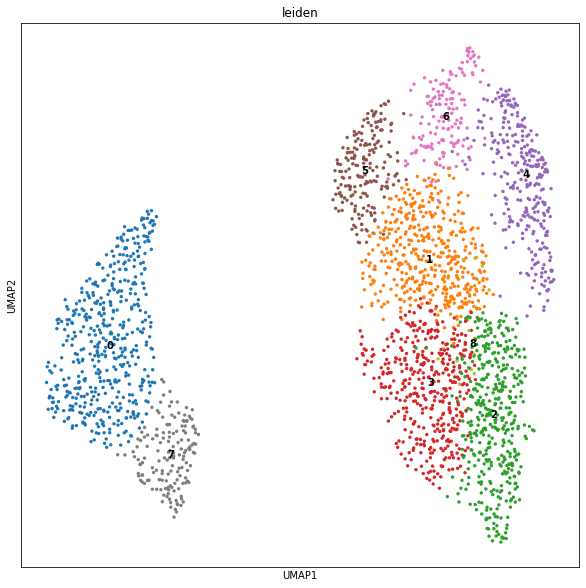

In [51]:
# lets use Leiden clustering
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data')

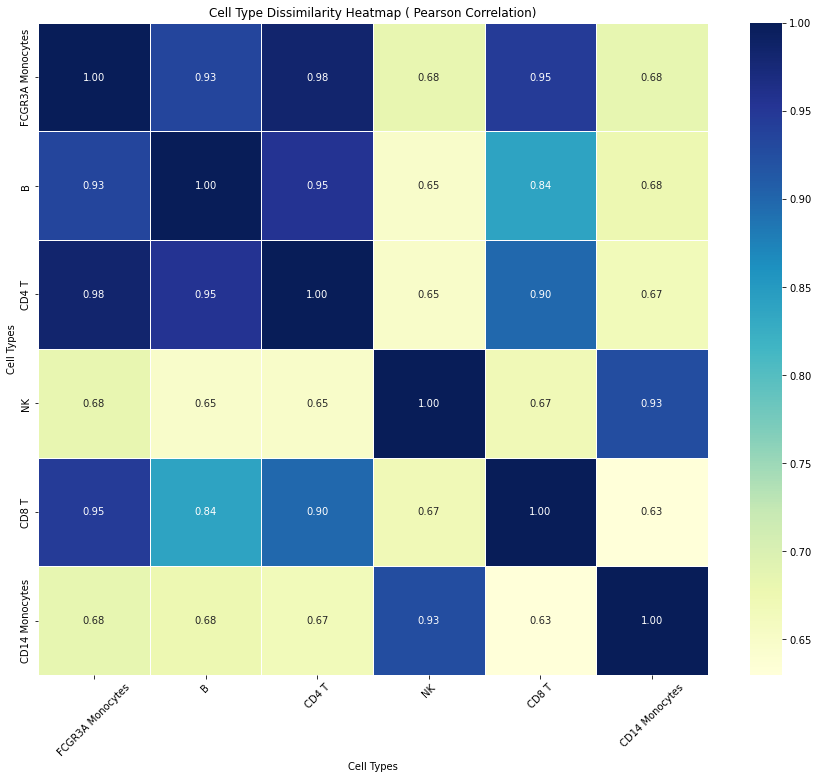

In [52]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = adata.obs["cell_types"].unique()
gene_ids = adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

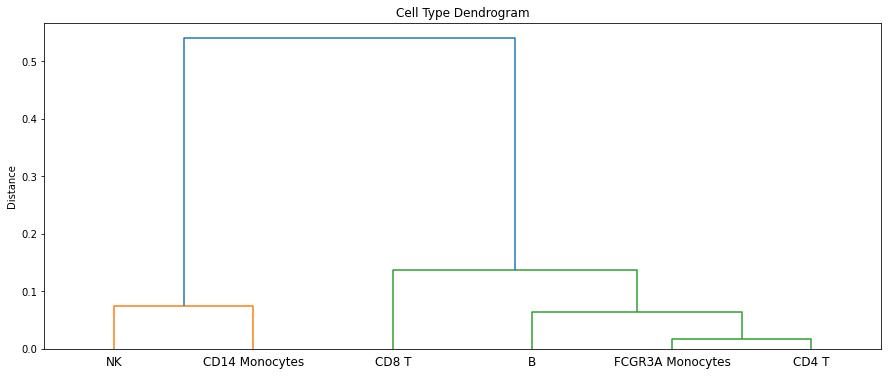

In [53]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

And Pseudobulk-creating loop for BayesPrism:

1. All Cell Types, All noise added
2. All Cell Types, No noise added
3. All Cell Types, No sample noise added (other noise is added)

Run all or one at a time as needed.

In [54]:
#assigning cell types to untransformed data
sn_adata = adata.copy()
Counter(sn_adata.obs["scpred_CellType"])

Counter({'FCGR3A Monocytes': 163,
         'B': 342,
         'CD4 T': 1131,
         'NK': 200,
         'CD8 T': 317,
         'CD14 Monocytes': 436})

## Defining Cell Types to delete from Reference

In [55]:
cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss

{0: [], 1: [2], 2: [0, 2], 3: [0, 2, 4], 4: [0, 2, 3, 4]}

## **Importing and QCing Pseudobulks**

All Cells Included in Reference:

In [56]:
num_cell_type_specific = 50 * int(adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

900

In [57]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=data_path, noise_type=f"{nt}_", file_name = pseudos_name, num_bulks_training = num_bulks, num_files=10, random_selection = False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


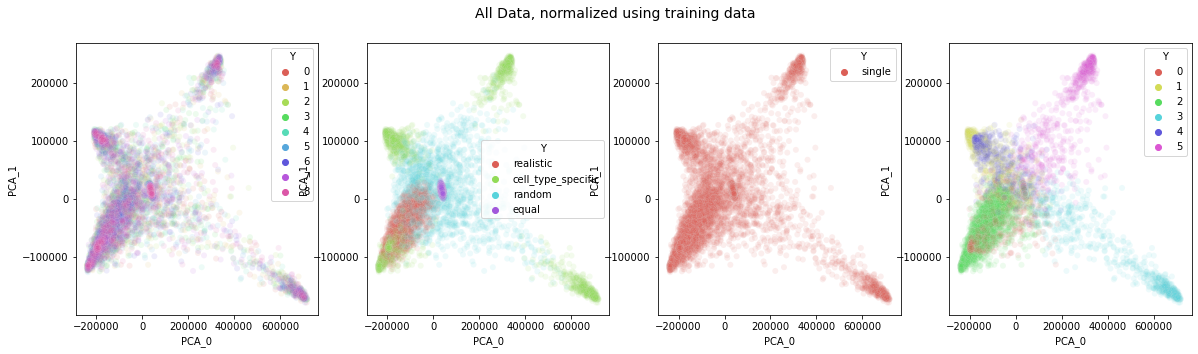

In [58]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.047s...
[t-SNE] Computed neighbors for 8000 samples in 9.776s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 3762.748053
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.683655
[t-SNE] KL divergence after 500 iterations: 1.404980
(8000, 2)
(8000, 2)


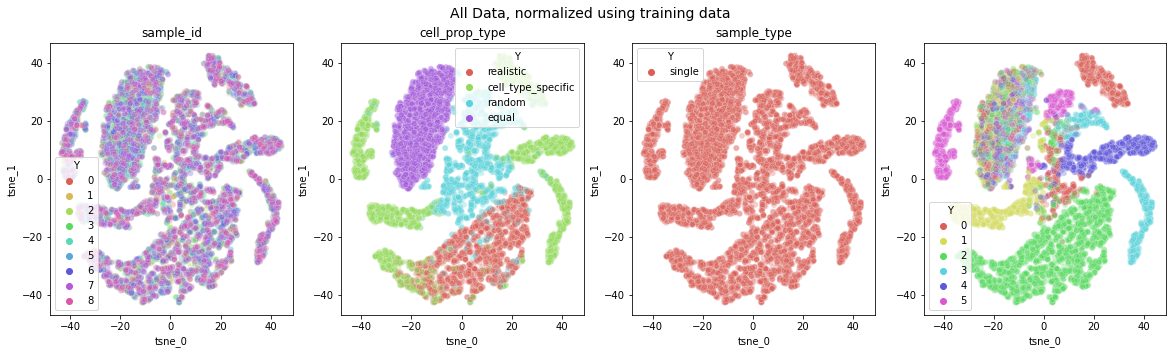

In [59]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_tsne_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)
fig.show()

In [60]:
gene_ids

AL627309.1       ENSG00000237683
AP006222.2       ENSG00000228463
RP11-206L10.2    ENSG00000228327
RP11-206L10.9    ENSG00000237491
LINC00115        ENSG00000225880
                      ...       
AC145212.1       ENSG00000215750
AL592183.1       ENSG00000220023
AL354822.1       ENSG00000215615
PNRC2-1          ENSG00000215700
SRSF10-1         ENSG00000215699
Name: gene_ids, Length: 13714, dtype: object

In [61]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == bulk_type)[0]
pseudos_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudos_df.index = range(0,len(pseudos_df))
prop_df.index = pseudos_df.index
meta_df.index = meta_df.index
pseudos_df

gene_ids,ENSG00000237683,ENSG00000228463,ENSG00000228327,ENSG00000237491,ENSG00000225880,ENSG00000188976,ENSG00000187961,ENSG00000187583,ENSG00000272512,ENSG00000188290,...,ENSG00000212907,ENSG00000198886,ENSG00000198786,ENSG00000198695,ENSG00000198727,ENSG00000215750,ENSG00000220023,ENSG00000215615,ENSG00000215700,ENSG00000215699
0,20.0,9.0,7.0,13.0,32.0,509.0,12.0,13.0,7.0,300.0,...,761.0,23559.0,4110.0,518.0,21025.0,40.0,662.0,11.0,199.0,96.0
1,36.0,6.0,3.0,11.0,46.0,543.0,15.0,17.0,19.0,500.0,...,750.0,23690.0,4139.0,509.0,20515.0,43.0,604.0,20.0,164.0,106.0
2,10.0,1.0,3.0,2.0,38.0,450.0,6.0,17.0,3.0,261.0,...,838.0,28137.0,4770.0,711.0,25316.0,22.0,615.0,6.0,242.0,83.0
3,18.0,3.0,3.0,17.0,39.0,732.0,17.0,12.0,10.0,1806.0,...,818.0,28487.0,5593.0,564.0,24353.0,48.0,660.0,39.0,208.0,143.0
4,9.0,4.0,1.0,11.0,37.0,536.0,18.0,16.0,10.0,950.0,...,828.0,29637.0,5080.0,697.0,25918.0,39.0,659.0,28.0,217.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,25.0,6.0,5.0,8.0,49.0,524.0,16.0,20.0,7.0,356.0,...,825.0,24748.0,4363.0,527.0,22015.0,33.0,639.0,17.0,210.0,94.0
1996,19.0,8.0,15.0,3.0,49.0,544.0,17.0,10.0,11.0,333.0,...,702.0,22518.0,3633.0,426.0,18567.0,24.0,706.0,22.0,181.0,103.0
1997,4.0,2.0,4.0,31.0,44.0,738.0,27.0,5.0,19.0,2451.0,...,924.0,29978.0,6034.0,532.0,24614.0,81.0,646.0,52.0,199.0,214.0
1998,7.0,3.0,3.0,1.0,35.0,612.0,15.0,22.0,0.0,388.0,...,829.0,25780.0,4161.0,574.0,21737.0,20.0,662.0,11.0,224.0,156.0


In [62]:
#adding gene ids as columns
pseudos_df.columns = gene_ids.index
pseudos_df

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,20.0,9.0,7.0,13.0,32.0,509.0,12.0,13.0,7.0,300.0,...,761.0,23559.0,4110.0,518.0,21025.0,40.0,662.0,11.0,199.0,96.0
1,36.0,6.0,3.0,11.0,46.0,543.0,15.0,17.0,19.0,500.0,...,750.0,23690.0,4139.0,509.0,20515.0,43.0,604.0,20.0,164.0,106.0
2,10.0,1.0,3.0,2.0,38.0,450.0,6.0,17.0,3.0,261.0,...,838.0,28137.0,4770.0,711.0,25316.0,22.0,615.0,6.0,242.0,83.0
3,18.0,3.0,3.0,17.0,39.0,732.0,17.0,12.0,10.0,1806.0,...,818.0,28487.0,5593.0,564.0,24353.0,48.0,660.0,39.0,208.0,143.0
4,9.0,4.0,1.0,11.0,37.0,536.0,18.0,16.0,10.0,950.0,...,828.0,29637.0,5080.0,697.0,25918.0,39.0,659.0,28.0,217.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,25.0,6.0,5.0,8.0,49.0,524.0,16.0,20.0,7.0,356.0,...,825.0,24748.0,4363.0,527.0,22015.0,33.0,639.0,17.0,210.0,94.0
1996,19.0,8.0,15.0,3.0,49.0,544.0,17.0,10.0,11.0,333.0,...,702.0,22518.0,3633.0,426.0,18567.0,24.0,706.0,22.0,181.0,103.0
1997,4.0,2.0,4.0,31.0,44.0,738.0,27.0,5.0,19.0,2451.0,...,924.0,29978.0,6034.0,532.0,24614.0,81.0,646.0,52.0,199.0,214.0
1998,7.0,3.0,3.0,1.0,35.0,612.0,15.0,22.0,0.0,388.0,...,829.0,25780.0,4161.0,574.0,21737.0,20.0,662.0,11.0,224.0,156.0


In [63]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudos_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudos_df = pseudos_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudos_df

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
1059,2.0,2.0,9.0,5.0,45.0,601.0,9.0,10.0,8.0,1192.0,...,782.0,27611.0,4719.0,441.0,22344.0,48.0,754.0,31.0,156.0,145.0
929,16.0,3.0,3.0,3.0,39.0,540.0,15.0,14.0,4.0,305.0,...,833.0,25361.0,4441.0,598.0,22413.0,13.0,666.0,8.0,239.0,125.0
1506,5.0,0.0,2.0,13.0,34.0,671.0,11.0,12.0,13.0,1772.0,...,882.0,29154.0,5604.0,528.0,24700.0,69.0,666.0,40.0,182.0,177.0
237,13.0,5.0,1.0,8.0,40.0,473.0,14.0,22.0,8.0,357.0,...,833.0,28217.0,4871.0,679.0,25274.0,19.0,637.0,18.0,232.0,96.0
1371,8.0,2.0,14.0,10.0,50.0,634.0,15.0,5.0,4.0,1057.0,...,783.0,25745.0,4473.0,450.0,21134.0,44.0,814.0,27.0,216.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,5.0,2.0,4.0,18.0,47.0,687.0,15.0,4.0,10.0,2143.0,...,888.0,29356.0,5643.0,536.0,24252.0,52.0,640.0,50.0,218.0,199.0
1132,2.0,6.0,4.0,14.0,39.0,650.0,10.0,15.0,13.0,1578.0,...,826.0,28041.0,5171.0,563.0,23493.0,56.0,725.0,43.0,246.0,176.0
1998,7.0,3.0,3.0,1.0,35.0,612.0,15.0,22.0,0.0,388.0,...,829.0,25780.0,4161.0,574.0,21737.0,20.0,662.0,11.0,224.0,156.0
1988,16.0,4.0,7.0,10.0,37.0,556.0,13.0,8.0,5.0,1035.0,...,883.0,27069.0,4973.0,557.0,22930.0,41.0,653.0,20.0,221.0,130.0


Putting together all reference expression and proportions.

In [64]:
# initializing dicitonaries of proportions and cell references.
all_refs = dict()
all_prop_refs_rebalanced = dict()
all_prop_refs = dict()

In [65]:
#with no cell missing is just the anndata object as is
#import anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)
#all cell types included QC
print(Counter(adata.obs.cell_types))
#to dense matrix and saving into path
dense_matrix = adata.X.todense()
dense_df = pd.DataFrame(dense_matrix, columns = sn_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=sn_adata.obs["cell_types"].to_list())
#save file later, with R index
dense_df.index = dense_df.index +  1
#qc
sig_df_sn = dense_df
print(sig_df_sn.shape)
all_refs[0] = sig_df_sn

Counter({'CD4 T': 1131, 'CD14 Monocytes': 436, 'B': 342, 'CD8 T': 317, 'NK': 200, 'FCGR3A Monocytes': 163})
(2589, 13715)


In [66]:
#opening anndata
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

#assigning the rest in a loop
for num in num_missing_cells:
    if num != 0:
        #dropping cell types missing from proportions
        all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
        all_prop_refs_rebalanced[num] = all_prop_refs[num]
        for idx,sample in all_prop_refs_rebalanced[num].iterrows():
            tot = np.sum(sample) #making them equal 1
            sample = sample / tot
    else: 
        all_prop_refs[num] = prop_df  
        all_prop_refs_rebalanced[num] = prop_df 
    #allign indexes with R
    all_prop_refs[num].index = all_prop_refs[num].index + 1
    all_prop_refs_rebalanced[num].index = all_prop_refs_rebalanced[num].index + 1
    #and save files
    #rebalances proportions
    sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulks_type}_proprebal.csv")
    sc_profile_path = Path(sc_profile_file)
    all_prop_refs_rebalanced[num].to_csv(sc_profile_path, index=False)
    #and not rebalances
    sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulks_type}_prop.csv")
    sc_profile_path = Path(sc_profile_file)
    all_prop_refs[num].to_csv(sc_profile_path, index=False)


In [67]:
#to dense matrix and copying into dict entry
dense_matrix = adata.X.todense()
dense_mat = dict()    
cell_states = dict()
cols = ["cell_id", "cell_type", "cell_subtype", "tumor_state"] #for cell state
for num in num_missing_cells:
    dense_mat[num] = dense_matrix.copy()
    #opening anndata
    #saving into path
    # sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_sig.csv")
    # sc_profile_path = Path(sc_profile_file)
    dense_df = pd.DataFrame(dense_mat[num], columns = adata.var['gene_ids'].index)
    dense_df.insert(loc=0, column='cell_types', value= adata.obs["cell_types"].to_list())
    for cell in cell_types[cells_to_miss[num]]:
        print(cell)
        dense_df = dense_df.drop(dense_df[dense_df["cell_types"] == cell].index)
    #save file
    dense_df.index = dense_df.index + 1

    #now creating the cell state file
    # cell_id, cell_type, cell_subtype and tumor_state
    cell_state = pd.DataFrame(columns = cols)
    cell_state["cell_type"] = dense_df["cell_types"].to_list()
    cell_state["cell_id"] = range(1,len(cell_state["cell_type"])+ 1 ) #+1 for R
    cell_state["cell_subtype"] = dense_df["cell_types"].to_list()
    cell_state["tumor_state"] = 0
    #change idx to start at 1 for R
    #save
    cell_states[num] = cell_state
    cellstate_path = os.path.join(aug_data_path, f"{res_name}_{bulks_type}_{num}missing_cellstate.csv")
    cellstate_path = Path(cellstate_path)
    cell_states[num].to_csv(cellstate_path, index = False)

    #dropping cell types, they're now in cell state
    dense_df.pop("cell_types")
    #dense_df.to_csv(sc_profile_path, index=True)
    all_refs[num] = dense_df
    #qc
    print(dense_df.shape)
    print(cell_state.shape)

(2589, 13714)
(2589, 4)
CD4 T
(1458, 13714)
(1458, 4)
FCGR3A Monocytes
CD4 T
(1295, 13714)
(1295, 4)
FCGR3A Monocytes
CD4 T
CD8 T
(978, 13714)
(978, 4)
FCGR3A Monocytes
CD4 T
NK
CD8 T
(778, 13714)
(778, 4)


In [68]:
mix = dict()
sig = dict()
for num in num_missing_cells:
    reference = all_refs[num]
    reference.index = range(1, len(reference)+1)
    bt = bulks_type
    #details
    num_str = str(num)  
    exp_id = str(res_name)
    #and create files for EXP2 BP
    mix[num], sig[num] = sn_sc_preprocess.write_bp_files(bp_path = aug_data_path, out_file_id = exp_id, 
                                         sig_df = reference,  X_train = pseudos_df, num_str = num_str, bulks_type= bt)
sig[0]

,1,2,3,4,5,6,7,8,9,10,...,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589
AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AP006222.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP11-206L10.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP11-206L10.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC00115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL592183.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL354822.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
PNRC2-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# mix[0] contains all pseudobulks
sc_profile_file = os.path.join(aug_data_path, f"{exp_id}_{bulks_type}_mixture.csv")
sc_profile_path = Path(sc_profile_file)
mix[0].to_csv(sc_profile_path, index= True)
mix[0]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
AL627309.1,2.0,16.0,5.0,13.0,8.0,15.0,1.0,6.0,7.0,5.0,...,22.0,10.0,10.0,18.0,22.0,5.0,2.0,7.0,16.0,10.0
AP006222.2,2.0,3.0,0.0,5.0,2.0,3.0,2.0,4.0,9.0,4.0,...,3.0,1.0,12.0,4.0,4.0,2.0,6.0,3.0,4.0,3.0
RP11-206L10.2,9.0,3.0,2.0,1.0,14.0,10.0,2.0,0.0,8.0,7.0,...,6.0,1.0,3.0,5.0,5.0,4.0,4.0,3.0,7.0,3.0
RP11-206L10.9,5.0,3.0,13.0,8.0,10.0,0.0,16.0,18.0,7.0,16.0,...,11.0,14.0,8.0,11.0,9.0,18.0,14.0,1.0,10.0,7.0
LINC00115,45.0,39.0,34.0,40.0,50.0,40.0,42.0,34.0,27.0,48.0,...,47.0,54.0,32.0,38.0,34.0,47.0,39.0,35.0,37.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,48.0,13.0,69.0,19.0,44.0,31.0,52.0,57.0,27.0,66.0,...,57.0,36.0,22.0,42.0,34.0,52.0,56.0,20.0,41.0,39.0
AL592183.1,754.0,666.0,666.0,637.0,814.0,662.0,697.0,680.0,744.0,634.0,...,653.0,640.0,667.0,569.0,552.0,640.0,725.0,662.0,653.0,722.0
AL354822.1,31.0,8.0,40.0,18.0,27.0,16.0,38.0,40.0,14.0,39.0,...,45.0,37.0,11.0,22.0,12.0,50.0,43.0,11.0,20.0,24.0
PNRC2-1,156.0,239.0,182.0,232.0,216.0,171.0,236.0,210.0,203.0,197.0,...,157.0,205.0,224.0,201.0,201.0,218.0,246.0,224.0,221.0,231.0


For the next step in processing, refer to R script EXP2_bayesprism_pbmc.R